Config loaded successfully.
Loading price data from: ..\data/raw/ using pattern: NQ*.txt
Found 42 price data files to process...
  Processing file 1/42: NQ 03-15.Last.txt
  Processing file 2/42: NQ 03-16.Last.txt
  Processing file 3/42: NQ 03-17.Last.txt
  Processing file 4/42: NQ 03-18.Last.txt
  Processing file 5/42: NQ 03-19.Last.txt
  Processing file 6/42: NQ 03-20.Last.txt
  Processing file 7/42: NQ 03-21.Last.txt
  Processing file 8/42: NQ 03-22.Last.txt
  Processing file 9/42: NQ 03-23.Last.txt
  Processing file 10/42: NQ 03-24.Last.txt
  Processing file 11/42: NQ 03-25.Last.txt
  Processing file 12/42: NQ 06-15.Last.txt
  Processing file 13/42: NQ 06-16.Last.txt
  Processing file 14/42: NQ 06-17.Last.txt
  Processing file 15/42: NQ 06-18.Last.txt
  Processing file 16/42: NQ 06-19.Last.txt
  Processing file 17/42: NQ 06-20.Last.txt
  Processing file 18/42: NQ 06-21.Last.txt
  Processing file 19/42: NQ 06-22.Last.txt
  Processing file 20/42: NQ 06-23.Last.txt
  Processing file 21

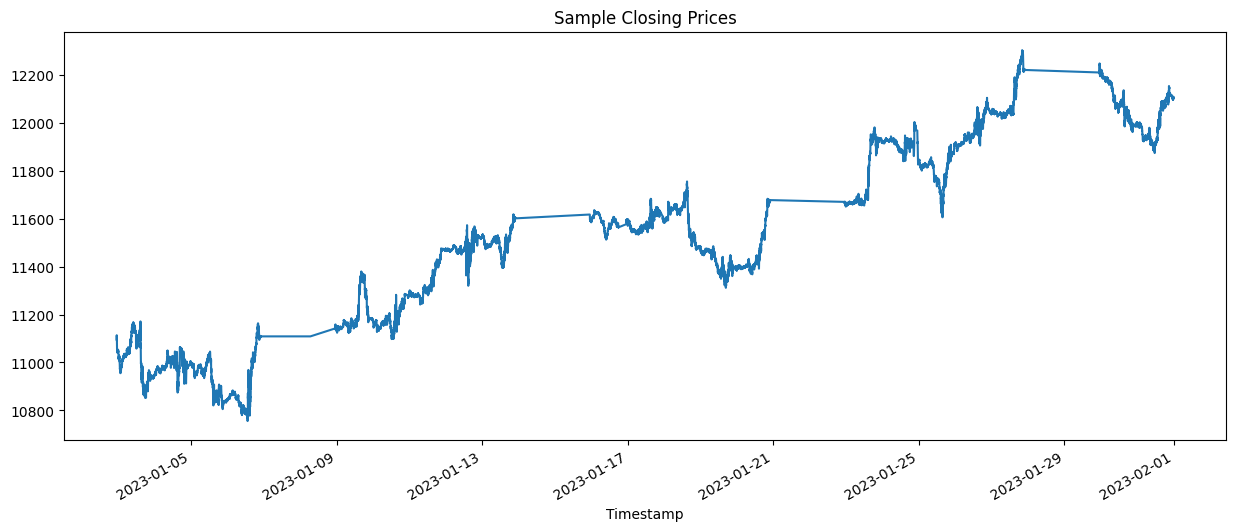

Loading trade data from: ..\data/raw/orb_trades.csv

Attempting to load trade data from: ..\data/raw/orb_trades.csv
Loaded trade data: 2051 trades
Processing Entry/Exit times...
Parsed Entry/Exit times successfully.
Processing currency/numeric columns...
Calculated 'Win' column (using Profit > 0.01)
Sample 'Profit' and 'Win' values after cleaning:
    Profit  Win
0   -160.0    0
1    870.0    1
2   -385.0    0
3   -370.0    0
4    865.0    1
5   -275.0    0
6   -875.0    0
7    815.0    1
8   -710.0    0
9   -345.0    0
10  -495.0    0
11  -655.0    0
12  -750.0    0
13  -700.0    0
14 -1050.0    0

Profit column stats:
count    2051.000000
mean      135.302292
std      1546.828110
min     -8895.000000
25%      -640.000000
50%      -175.000000
75%       700.000000
max      9655.000000
Name: Profit, dtype: float64

Win column distribution:
Win
0    0.595319
1    0.404681
Name: proportion, dtype: float64

Unnamed: 19    2051
dtype: int64

Cleaned trade data. Final shape: 2051 trades
Trad

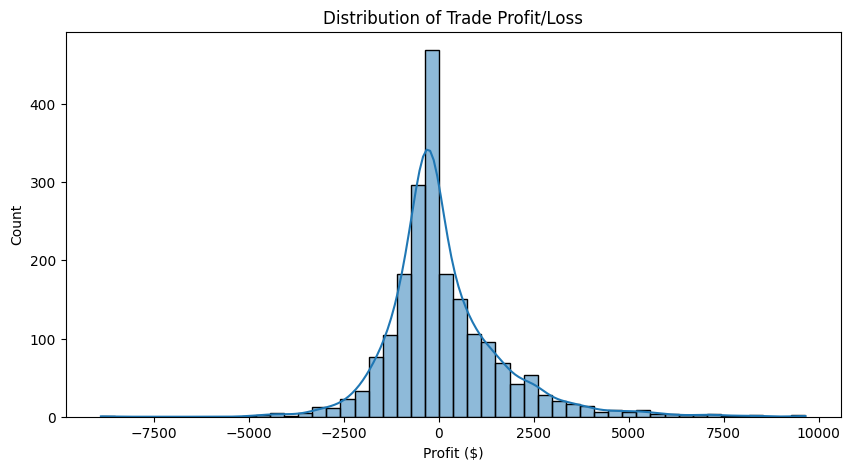

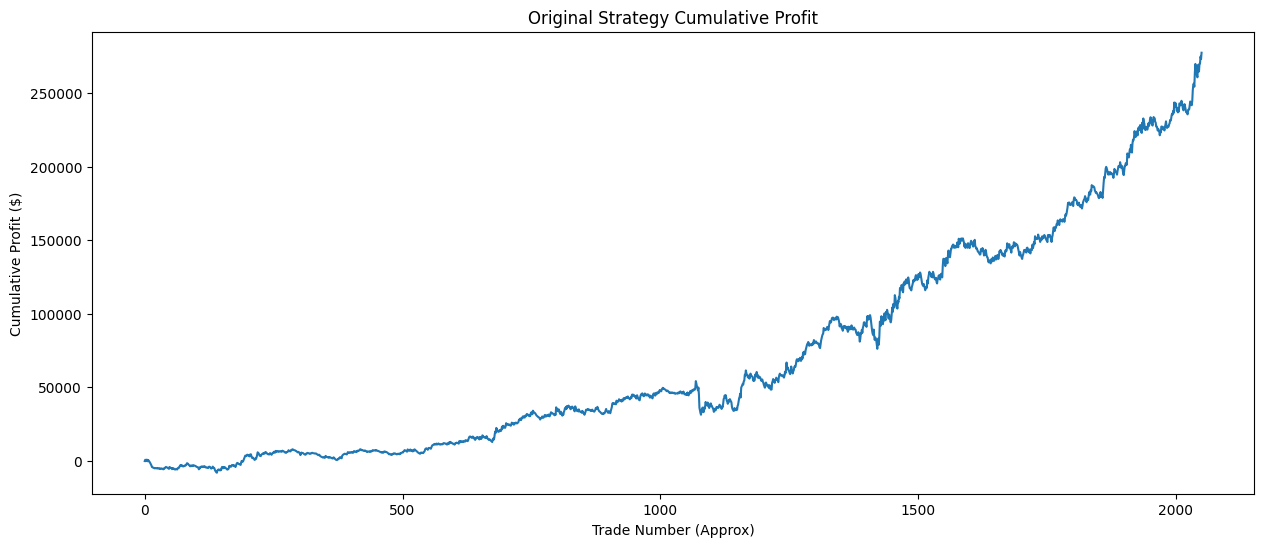

Processed price data saved successfully to: ..\data/processed/price_data_processed.parquet


In [1]:
# %% [markdown]
# # 1. Data Exploration and Cleaning
#
# **Purpose:** Load raw price and trade data, perform initial cleaning, visualize, check for anomalies, and save processed price data.

# %%
import pandas as pd
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom functions
import sys
# Add src directory to path for importing modules
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from data_processing import load_price_data, load_trade_data

# Set display options for pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

# %% [markdown]
# ## Load Configuration

# %%
CONFIG_PATH = '../config/config.yaml'
try:
    with open(CONFIG_PATH, 'r') as f:
        config = yaml.safe_load(f)
    print("Config loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: Config file not found at {CONFIG_PATH}")
    config = None
except Exception as e:
    print(f"ERROR loading config: {e}")
    config = None

if config is None:
    raise ValueError("Failed to load configuration.")

# Define data paths from config
RAW_DATA_DIR = os.path.join('..', config['data_paths']['raw_data_dir'])
PROCESSED_DIR = os.path.join('..', config['data_paths']['processed_dir'])
PRICE_FILE_PATTERN = config['data_paths']['price_file_pattern']
TRADE_LOG_FILE = config['data_paths']['trade_log_file']
PROCESSED_PRICE_FILE = os.path.join(PROCESSED_DIR, config['processed_files']['price_data'])

# Create processed directory if it doesn't exist
os.makedirs(PROCESSED_DIR, exist_ok=True)

# %% [markdown]
# ## Load Raw Price Data
# This function will find all files matching the pattern in the raw data directory, load them, parse timestamps, clean, concatenate, sort, and remove duplicates.

# %%
print(f"Loading price data from: {RAW_DATA_DIR} using pattern: {PRICE_FILE_PATTERN}")
price_df = load_price_data(RAW_DATA_DIR, PRICE_FILE_PATTERN)

# %% [markdown]
# ## Explore Price Data

# %%
if price_df is not None:
    print("Price Data Info:")
    price_df.info()
    print("\nPrice Data Head:")
    print(price_df.head())
    print("\nPrice Data Tail:")
    print(price_df.tail())
    print("\nPrice Data Description:")
    print(price_df.describe())

    # Check for NaNs
    print("\nNaNs per column:")
    print(price_df.isnull().sum())

    # Basic Plot (e.g., closing prices for a sample period)
    print("\nPlotting sample closing prices...")
    sample_period = price_df['2023-01-01':'2023-01-31'] if '2023-01-01' in price_df.index else price_df.tail(5000)
    if not sample_period.empty:
         plt.figure(figsize=(15, 6))
         sample_period['Close'].plot(title='Sample Closing Prices')
         plt.show()
    else:
         print("Could not create sample plot (data range might be different).")

else:
    print("Price data loading failed.")


# %% [markdown]
# ## Load Raw Trade Data
# This loads the CSV trade log generated by NinjaTrader.

# %%
trade_log_path = os.path.join(RAW_DATA_DIR, TRADE_LOG_FILE)
print(f"Loading trade data from: {trade_log_path}")
trade_df = load_trade_data(trade_log_path)

# %% [markdown]
# ## Explore Trade Data

# %%
if trade_df is not None:
    print("Trade Data Info:")
    trade_df.info()
    print("\nTrade Data Head:")
    print(trade_df.head())
    print("\nTrade Data Description:")
    print(trade_df.describe())

    # Check for NaNs
    print("\nNaNs per column:")
    print(trade_df.isnull().sum())

    # Plot Profit/Loss distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(trade_df['Profit'], bins=50, kde=True)
    plt.title('Distribution of Trade Profit/Loss')
    plt.xlabel('Profit ($)')
    plt.show()

    # Plot cumulative profit
    plt.figure(figsize=(15, 6))
    trade_df['Cum. net profit'].plot(title='Original Strategy Cumulative Profit')
    plt.ylabel('Cumulative Profit ($)')
    plt.xlabel('Trade Number (Approx)') # Index is trade number if not reset
    plt.show()

else:
    print("Trade data loading failed.")

# %% [markdown]
# ## Save Processed Price Data
# Save the cleaned, combined, and sorted price data to a Parquet file for faster loading in subsequent steps.

# %%
if price_df is not None:
    try:
        price_df.to_parquet(PROCESSED_PRICE_FILE)
        print(f"Processed price data saved successfully to: {PROCESSED_PRICE_FILE}")
    except Exception as e:
        print(f"ERROR saving processed price data: {e}")
else:
    print("Skipping saving price data as loading failed.")

# %% [markdown]
# ---
# End of Notebook 01
# ---